In [1]:
! pip install skforecast

In [1]:
# Manejo de datos
import numpy as np
import pandas as pd
import os
from datetime import datetime

# Gráficos
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Preprocesado y modelado
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import joblib

import skforecast
from skforecast.recursive import ForecasterRecursive
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import grid_search_forecaster
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# Configuración warnings (Quitar en caso de errores desconocidos)
import warnings
warnings.filterwarnings('ignore')

# Versión de paquetes usados
color = '\033[1m\033[38;5;208m'
print(f"{color}Versión de las librerias utilizadas:")
print(f"{color}- Version skforecast: {skforecast.__version__}")
print(f"{color}- Version scikit-learn: {sklearn.__version__}")
print(f"{color}- Version pandas: {pd.__version__}")
print(f"{color}- Version numpy: {np.__version__}")

Versión de las librerias utilizadas:
- Version skforecast: 0.19.0
- Version scikit-learn: 1.7.2
- Version pandas: 2.3.3
- Version numpy: 2.2.6


c:\Users\tcidm\Desktop\Material de la U\AnalisisDatos\Proyecto_Central_ADD\venv_310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
try:
    df = pd.read_csv("Datasets/accesos_biblioteca.csv")
    print("Dataset cargado desde 'Datasets/accesos_biblioteca.csv'")
except FileNotFoundError:
    print("ERROR: No se encontró el archivo 'accesos_biblioteca.csv'.")
    exit(1)

Dataset cargado desde 'Datasets/accesos_biblioteca.csv'


In [3]:
print("Dataset original - Columnas iniciales:")
print(f"Columnas: {list(df.columns)}")
print(f"Forma del dataset: {df.shape}")
print("\nPrimeras 3 filas:")
print(df.head(3))

Dataset original - Columnas iniciales:
Columnas: ['Fecha', 'Día', 'Mes', 'Año', 'Semestre', 'Accesos', 'Vacaciones?']
Forma del dataset: (511, 7)

Primeras 3 filas:
        Fecha  Día  Mes   Año  Semestre  Accesos  Vacaciones?
0  2023-12-14   14   12  2023         2      953            0
1  2023-12-15   15   12  2023         2      549            0
2  2023-12-16   16   12  2023         2       71            0


In [4]:
def agregar_lags(df, columna, lags):
    for lag in lags:
        df[f'lag_{lag}'] = df[columna].shift(lag)
    return df

def agregar_medias_moviles(df, columna, ventanas):
    for ventana in ventanas:
        df[f'media_movil_{ventana}'] = df[columna].shift(1).rolling(window=ventana, min_periods=1).mean()
    return df

def agregar_variables_ciclicas(df, columna_mes, columna_fecha):
    df['mes_sin'] = np.sin(2 * np.pi * df[columna_mes] / 12)
    df['mes_cos'] = np.cos(2 * np.pi * df[columna_mes] / 12)
    df['dia_semana_sin'] = np.sin(2 * np.pi * pd.to_datetime(df[columna_fecha]).dt.weekday / 7)
    df['dia_semana_cos'] = np.cos(2 * np.pi * pd.to_datetime(df[columna_fecha]).dt.weekday / 7)
    return df

def agregar_ewma(df, columna, spans):
    for span in spans:
        df[f'ewma_{span}'] = df[columna].shift(1).ewm(span=span, adjust=False).mean()
    return df

In [5]:
def obtener_semestre(mes):
    if 3 <= mes <= 7:
        return 1  # Primer semestre
    elif 8 <= mes <= 12:
        return 2  # Segundo semestre
    else:
        return 0  # Fuera de semestre (enero, febrero)
    
def obtener_semana_semestre(fecha):
    mes = fecha.month
    dia = fecha.day
    if 3 <= mes <= 7:
        inicio_semestre = datetime(fecha.year, 3, 1)
    elif 8 <= mes <= 12:
        inicio_semestre = datetime(fecha.year, 8, 1)
    else:
        return 0  # Fuera de semestre
    delta = fecha - inicio_semestre
    semana_semestre = delta.days // 7 + 1
    return semana_semestre

In [ ]:
for col in ['Accesos']:
    df[col] = df[col].fillna(0).astype(int)

df = df[
    pd.to_datetime(df['Fecha']).dt.weekday != 6
].reset_index(drop=True)

df = agregar_medias_moviles(df, 'Accesos', [7, 14, 30])
df = agregar_variables_ciclicas(df, 'Mes', 'Fecha')
df = agregar_ewma(df, 'Accesos', [7, 14, 30])

df['Semestre'] = df['Mes'].apply(obtener_semestre)
df['Semana_Semestre'] = pd.to_datetime(df['Fecha']).apply(obtener_semana_semestre)

df['Fecha'] = pd.to_datetime(df['Fecha'])

df = agregar_lags(df, 'Accesos', [7, 14, 21])

df = df.dropna().reset_index(drop=True)
df.tail(5)

,Fecha,Día,Mes,Año,Semestre,Accesos,Vacaciones?,media_movil_7,media_movil_14,media_movil_30,mes_sin,mes_cos,dia_semana_sin,dia_semana_cos,ewma_7,ewma_14,ewma_30,Semana_Semestre
433,2025-05-02,2,5,2025,1,0,1,1585.571429,1941.642857,2525.500000,0.5,-0.866025,-0.433884,-0.900969,1525.983140,1921.208321,2153.063866,9
434,2025-05-03,3,5,2025,1,0,1,1222.142857,1645.571429,2445.066667,0.5,-0.866025,-0.974928,-0.222521,1144.487355,1665.047212,2014.156520,10
435,2025-05-05,5,5,2025,1,2750,0,1028.428571,1531.857143,2438.466667,0.5,-0.866025,0.000000,1.000000,858.365516,1443.040917,1884.210938,10
436,2025-05-06,6,5,2025,1,1866,0,1346.142857,1728.285714,2417.700000,0.5,-0.866025,0.781831,0.623490,1331.274137,1617.302128,1940.068296,10
437,2025-05-07,7,5,2025,1,2254,0,1269.857143,1861.571429,2362.766667,0.5,-0.866025,0.974928,-0.222521,1464.955603,1650.461844,1935.289697,10


In [14]:
print("=== NUEVAS COLUMNAS CREADAS POR INGENIERÍA DE CARACTERÍSTICAS ===\n")

# Columnas originales del dataset base
columnas_originales = ['Fecha', 'Día', 'Mes', 'Año', 'Vacaciones', 'Accesos']

# Mostrar todas las columnas actuales
columnas_actuales = list(df.columns)
nuevas_columnas = [col for col in columnas_actuales if col not in columnas_originales]

print("📊 DATASET ORIGINAL:")
print(f"   Columnas: {columnas_originales}")
print(f"   Total: {len(columnas_originales)} columnas\n")

print("🔧 NUEVAS COLUMNAS AGREGADAS:")
for i, col in enumerate(nuevas_columnas, 1):
    print(f"   {i:2d}. {col}")

print(f"\n📈 RESUMEN:")
print(f"   • Columnas originales: {len(columnas_originales)}")
print(f"   • Nuevas columnas: {len(nuevas_columnas)}")
print(f"   • Total final: {len(columnas_actuales)} columnas")
print(f"   • Shape del dataset: {df.shape}")

print(f"\n🎯 CATEGORÍAS DE NUEVAS CARACTERÍSTICAS:")
print("   • Variables de tendencia: media_movil_7, media_movil_14, media_movil_30")
print("   • Variables cíclicas: mes_sin, mes_cos, dia_semana_sin, dia_semana_cos") 
print("   • Medias exponenciales: ewma_7, ewma_14, ewma_30")
print("   • Variables académicas: Semestre, Semana_Semestre, Semana_Certamen")
print("   • Variables lag: lag_7, lag_14, lag_21 (se agregarán después)")

# Mostrar una muestra del dataset con las nuevas columnas
print("\n📋 MUESTRA DEL DATASET CON NUEVAS COLUMNAS:")
print(df[['Fecha', 'Accesos'] + nuevas_columnas[:5]].head(3))

=== NUEVAS COLUMNAS CREADAS POR INGENIERÍA DE CARACTERÍSTICAS ===

📊 DATASET ORIGINAL:
   Columnas: ['Fecha', 'Día', 'Mes', 'Año', 'Vacaciones', 'Accesos']
   Total: 6 columnas

🔧 NUEVAS COLUMNAS AGREGADAS:
    1. Semestre
    2. Vacaciones?
    3. media_movil_7
    4. media_movil_14
    5. media_movil_30
    6. mes_sin
    7. mes_cos
    8. dia_semana_sin
    9. dia_semana_cos
   10. ewma_7
   11. ewma_14
   12. ewma_30
   13. Semana_Semestre
   14. lag_7
   15. lag_14
   16. lag_21

📈 RESUMEN:
   • Columnas originales: 6
   • Nuevas columnas: 16
   • Total final: 21 columnas
   • Shape del dataset: (417, 21)

🎯 CATEGORÍAS DE NUEVAS CARACTERÍSTICAS:
   • Variables de tendencia: media_movil_7, media_movil_14, media_movil_30
   • Variables cíclicas: mes_sin, mes_cos, dia_semana_sin, dia_semana_cos
   • Medias exponenciales: ewma_7, ewma_14, ewma_30
   • Variables académicas: Semestre, Semana_Semestre, Semana_Certamen
   • Variables lag: lag_7, lag_14, lag_21 (se agregarán después)

📋 MU

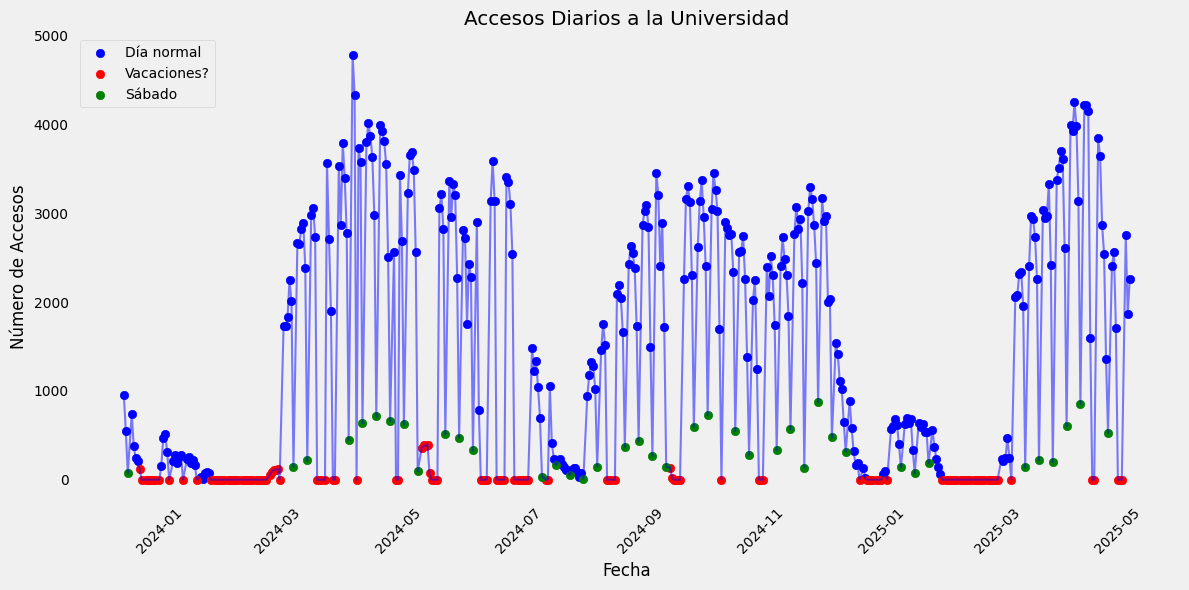

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(df['Fecha'], df['Accesos'], linestyle='-', color='b', alpha=0.5)

# Puntos normales (no vacaciones ni sábados)
no_vac_no_sab = (df['Vacaciones?'] == 0) & (df['Fecha'].dt.weekday != 5)
plt.scatter(df['Fecha'][no_vac_no_sab], df['Accesos'][no_vac_no_sab], color='b', label='Día normal')

# Puntos de vacaciones
vac = (df['Vacaciones?'] == 1)
plt.scatter(df['Fecha'][vac], df['Accesos'][vac], color='r', label='Vacaciones?')

# Puntos de sábados
sab = (df['Vacaciones?'] == 0) & (df['Fecha'].dt.weekday == 5)
plt.scatter(df['Fecha'][sab], df['Accesos'][sab], color='g', label='Sábado')

plt.title('Accesos Diarios a la Universidad')
plt.xlabel('Fecha')
plt.ylabel('Número de Accesos')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
X = df.drop(columns=['Fecha', 'Accesos'])
y = df['Accesos']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

print(f"Datos de entrenamiento: {len(X_train)}")
print(f"Datos de prueba: {len(X_test)}")

Datos de entrenamiento: 333
Datos de prueba: 84


In [ ]:
print("=== DATASET FINAL DESPUÉS DE INGENIERÍA DE CARACTERÍSTICAS ===\n")

# Mostrar todas las columnas finales organizadas por categoría
print("📊 COLUMNAS ORGANIZADAS POR CATEGORÍA:")

print("\n🔹 Variables originales:")
originales = ['Fecha', 'Día', 'Mes', 'Año', 'Vacaciones', 'Accesos']
for col in originales:
    if col in df.columns:
        print(f"   • {col}")

print("\n🔹 Variables de tendencia/suavizado:")
tendencia = [col for col in df.columns if 'media_movil' in col or 'ewma' in col]
for col in tendencia:
    print(f"   • {col}")

print("\n🔹 Variables cíclicas/temporales:")
ciclicas = [col for col in df.columns if any(x in col for x in ['sin', 'cos'])]
for col in ciclicas:
    print(f"   • {col}")

print("\n🔹 Variables del contexto académico:")
academicas = [col for col in df.columns if any(x in col for x in ['Semestre', 'Semana', 'Certamen'])]
for col in academicas:
    print(f"   • {col}")

print("\n🔹 Variables lag (retardos temporales):")
lags = [col for col in df.columns if 'lag_' in col]
for col in lags:
    print(f"   • {col}")

print(f"\n📈 RESUMEN FINAL:")
print(f"   • Total de columnas: {len(df.columns)}")
print(f"   • Filas en el dataset: {len(df)}")
print(f"   • Nuevas características creadas: {len(df.columns) - 6}")  # 6 son las originales

=== DATASET FINAL DESPUÉS DE INGENIERÍA DE CARACTERÍSTICAS ===

📊 COLUMNAS ORGANIZADAS POR CATEGORÍA:

🔹 Variables originales:
   • Fecha
   • Día
   • Mes
   • Año
   • Accesos

🔹 Variables de tendencia/suavizado:
   • media_movil_7
   • media_movil_14
   • media_movil_30
   • ewma_7
   • ewma_14
   • ewma_30

🔹 Variables cíclicas/temporales:
   • mes_sin
   • mes_cos
   • dia_semana_sin
   • dia_semana_cos

🔹 Variables del contexto académico:
   • Semestre
   • Semana_Semestre
   • Semana_Certamen

🔹 Variables lag (retardos temporales):
   • lag_7
   • lag_14
   • lag_21

📈 RESUMEN FINAL:
   • Total de columnas: 22
   • Filas en el dataset: 320
   • Nuevas características creadas: 16


In [11]:
os.makedirs('Archivos Auxiliares', exist_ok=True)
if "modelo_RandomForest.pkl" not in os.listdir('Archivos Auxiliares'):
    print("Entrenando el modelo Random Forest")
    model = RandomForestRegressor(
        n_estimators=100,
        max_depth=5,
        random_state=42
    )
    model.fit(X_train, y_train)

    tscv = TimeSeriesSplit(n_splits=5)
    param_grid = {
        'n_estimators': [100, 300, 500],
        'max_depth': [3, 5, 8, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': [None, 'sqrt', 'log2']
    }

    grid_search = GridSearchCV(
        RandomForestRegressor(random_state=42),
        param_grid,
        cv=tscv,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    print(f'Mejores parámetros: {grid_search.best_params_}')

    best_params = grid_search.best_params_
    model = RandomForestRegressor(**best_params, random_state=42)
    model.fit(X_train, y_train)
    joblib.dump(model, 'Archivos Auxiliares/modelo_RandomForest.pkl')
    print("Modelo guardado como 'Archivos Auxiliares/modelo_RandomForest.pkl'")
else:
    model = joblib.load('Archivos Auxiliares/modelo_RandomForest.pkl')
    print("Modelo cargado desde 'Archivos Auxiliares/modelo_RandomForest.pkl'")

Entrenando el modelo Random Forest
Mejores parámetros: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Modelo guardado como 'Archivos Auxiliares/modelo_RandomForest.pkl'


In [12]:
predicted = model.predict(X_test)
predicted = np.maximum(predicted, 0)

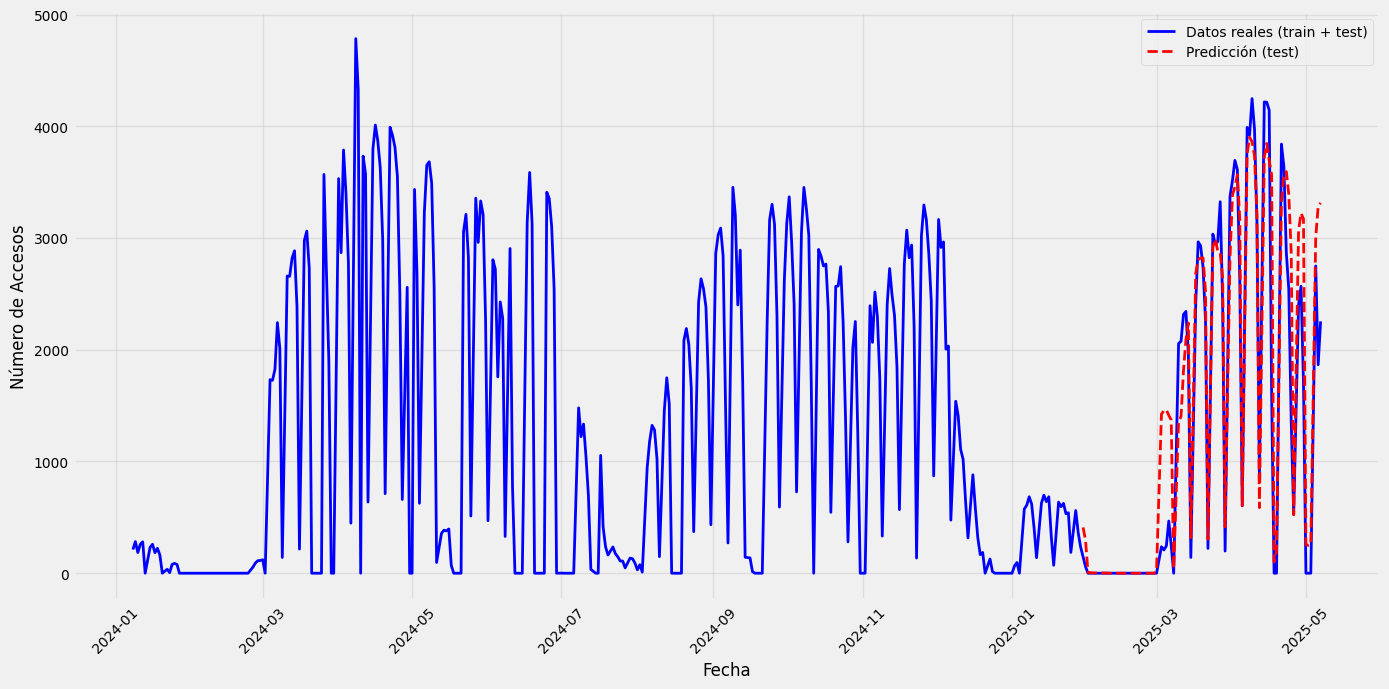

R²: 0.87
Error Cuadrático Medio (MSE): 290318.29
Error Cuadrático Medio Raíz (RMSE): 538.81
Error Absoluto Medio (MAE): 324.82


In [13]:
fechas = df['Fecha']
plt.figure(figsize=(14, 7))
plt.plot(fechas, df['Accesos'], label='Datos reales (train + test)', color='blue', linewidth=2)
plt.plot(fechas.loc[X_test.index], predicted, label='Predicción (test)', color='red', linestyle='--', linewidth=2)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Número de Accesos', fontsize=12)
plt.xticks(rotation=45)
plt.legend(fontsize=10)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

mse = mean_squared_error(y_test, predicted)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predicted)
r2 = r2_score(y_test, predicted)
print(f"R²: {r2:.2f}")
print(f"Error Cuadrático Medio (MSE): {mse:.2f}")
print(f"Error Cuadrático Medio Raíz (RMSE): {rmse:.2f}")
print(f"Error Absoluto Medio (MAE): {mae:.2f}")